In [1]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *
from utils.prediction_models import _pickleable_run_model

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

## Calculate data

In [5]:
def l2_dist_matrix(df):
    X=df.values
    X2=np.sum(X**2,axis=1,keepdims=True)
    out=np.sqrt((X2+X2.T-2*X @ X.T)/df.shape[1])
    out=pd.DataFrame(out,index=df.index,columns=df.index)
    return out

def cal_distance(kos_data, growth_data, tree,carbons=None):
    
    print("Calculating distance matrix")
    tree_matrix=cal_dist_matrix_efficient(tree)

    print("Calculating genome distance matrix")
    genome_distance_matrix=l2_dist_matrix(kos_data)


    if carbons is None:
        carbons=growth_data.columns
    carbon_dms={}
    for carbon in tqdm(carbons,desc="Calculating growth distance matrix"):
        carbon_dms[carbon]=l2_dist_matrix(growth_data[[carbon]].dropna())
    
    print("Merging dataframes")

    def to_long_form(mat, name):
        ind_name=mat.index.name
        if ind_name is None:
            ind_name="index"
        return mat.reset_index().melt(id_vars=[ind_name],value_vars=mat.columns, var_name='s2',value_name=name).rename(columns={ind_name:"s1"})
    
    out=to_long_form(tree_matrix,"tree_distance")
    out['s1_s12']=out['s1']+"_"+out['s2']
    out=out.merge(to_long_form(genome_distance_matrix,"genome_distance"),on=["s1","s2"],how="left")
    for carbon in tqdm(carbons,desc="Merging dataframes"):
        out=out.merge(to_long_form(carbon_dms[carbon],carbon+"_distance"),on=["s1","s2"],how="left")
    
    return out[out['s1']!=out['s2']]

In [6]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B"

### Zeqian

In [6]:
zl_distance=cal_distance(zeqian['ko_data'],zeqian['growth_data'],zeqian['tree'])
zl_distance.to_pickle(f"{DIR_data}/zeqian_distance.pk")

Calculating distance matrix
Calculating genome distance matrix


Calculating growth distance matrix: 100%|██████████| 10/10 [00:00<00:00, 1061.50it/s]


Merging dataframes


Merging dataframes: 100%|██████████| 10/10 [00:00<00:00, 195.56it/s]


In [7]:
matti_distance=cal_distance(matti['ko_data'],matti['growth_data'],matti['tree'])
matti_distance.to_pickle(f"{DIR_data}/matti_distance.pk")

Calculating distance matrix
Calculating genome distance matrix


Calculating growth distance matrix: 100%|██████████| 100/100 [00:00<00:00, 1137.51it/s]


Merging dataframes


Merging dataframes: 100%|██████████| 100/100 [00:01<00:00, 62.42it/s]


The bacdive dataframe is too big in long form. Store seperately.

In [ ]:
# bacdive_distance=cal_distance(bacdive['kos_data'],bacdive['growth_data'],bacdive['tree'])
# bacdive_distance.to_pickle(f"{DIR_data}/matti_distance.pk")

### BacDive

In [7]:
# This is fast (~20s)
kos_data, growth_data, tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree']

print("Calculating distance matrix")
tree_matrix=cal_dist_matrix_efficient(tree)

tree_matrix.to_pickle(f"{DIR_data}/bacdive_tree_distance_matrix.pk")



Calculating distance matrix


In [8]:
carbon_dms={}
for carbon in tqdm(growth_data.columns,desc="Calculating growth distance matrix"):
    carbon_dms[carbon]=l2_dist_matrix(growth_data[[carbon]].dropna())

with open(f"{DIR_data}/bacdive_trait_distance_matrix.pk", "wb") as f:
    pickle.dump(carbon_dms, f)

Calculating growth distance matrix: 100%|██████████| 58/58 [00:00<00:00, 302.86it/s]


In [12]:
# This takes about 30 minutes
print("Calculating genome distance matrix")
genome_distance_matrix=l2_dist_matrix(kos_data)
genome_distance_matrix.to_pickle(f"{DIR_data}/bacdive_genome_distance_matrix.pk")

Calculating genome distance matrix


## Chi-square test

In [33]:
from scipy.stats import chi2_contingency

def cal_chi2(dist, trait_dist, key=None,
            scan_range=(None,None),n_scan=500, 
            min_pair=10,p_threshold=0.05,bin_size=None,
            ):

    if isinstance(trait_dist, pd.DataFrame):
        # passed two distance matrices
        if trait_dist.shape[0]!=trait_dist.shape[1]:
            raise ValueError
        trait_dist=trait_dist.dropna(axis=0,how='all').dropna(axis=1,how='all')
        samples=np.intersect1d(trait_dist.index.values, trait_dist.columns.values)
        trait_dist=trait_dist.loc[samples,samples].values
        dist=dist.loc[samples,samples].values
        N=len(samples)**2
    else:
        # passed two 1d arrays
        _ind=pd.notna(trait_dist)
        dist=dist[_ind]
        trait_dist=trait_dist[_ind]
        if len(dist)!=len(trait_dist):
            raise ValueError
        N=len(dist)
    _1=(trait_dist>0.5).astype(int)
    n_1=_1.sum() # number of strain pairs with different traits

    scan_low, scan_high=scan_range
    if scan_low is None:
        scan_low=dist.min()
    if scan_high is None:
        scan_high=dist.max()
    stat=[]
    for thresh in np.linspace(scan_low,scan_high,n_scan,endpoint=True):
        _below_thresh=(dist<thresh).astype(int)
        if bin_size is not None:
            _below_thresh=_below_thresh*((dist>=(thresh-bin_size)).astype(int))
        n_below_thresh=_below_thresh.sum()
        if n_below_thresh<min_pair:
            continue
        n_below_1=(_1 * _below_thresh).sum()
        contingency=[[n_below_1, n_below_thresh-n_below_1],[n_1-n_below_1, N-n_1-n_below_thresh+n_below_1]]
        chisq, p,dof,expected=chi2_contingency(contingency)
        stat.append({'thresh':thresh, 'chisq':chisq, 'p':p, 'dof':dof})
    stat=pd.DataFrame(stat).sort_values('thresh')
    if key is not None:
        stat['key']=key
    
    ns=stat['p']>=p_threshold
    if ns.iat[0]:
        cutoff=0  # no correlation
    elif ns.any():
        cutoff=stat[ns]['thresh'].min()
    else:
        cutoff=scan_high

    return stat, cutoff

In [34]:
# Zeqian data
DIR_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B"
df_dist=pd.read_pickle(f"{DIR_data}/zeqian_distance.pk")

stats,cutoffs=[],[]
p_threshold=0.05
for c in tqdm(zeqian['carbons']):
    stat,cutoff=cal_chi2(df_dist['tree_distance'].values,df_dist[c+'_distance'].values,key=c,p_threshold=p_threshold,bin_size=0.1,scan_range=(0.05,3))
    stats.append(stat)
    cutoffs.append({'carbon_name':c,'cutoff':cutoff,'p_threshold':p_threshold})

stats=pd.concat(stats,axis=0,ignore_index=True)
cutoffs=pd.DataFrame(cutoffs)

with open(f"{DIR_data}/zeqian_chi2.pk", 'wb') as f:
    pickle.dump({'stats':stats, 'cutoffs':cutoffs}, f)

100%|██████████| 10/10 [00:00<00:00, 20.41it/s]


In [46]:
# matti data
DIR_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B"
df_dist=pd.read_pickle(f"{DIR_data}/matti_distance.pk")

stats,cutoffs=[],[]
p_threshold=0.05
for c in tqdm(matti['carbons']):
    stat,cutoff=cal_chi2(df_dist['tree_distance'].values,df_dist[c+'_distance'].values,key=c,p_threshold=p_threshold,bin_size=0.1,scan_range=(0.05,3))
    stats.append(stat)
    cutoffs.append({'carbon_name':c,'cutoff':cutoff,'p_threshold':p_threshold})

stats=pd.concat(stats,axis=0,ignore_index=True)
cutoffs=pd.DataFrame(cutoffs)


with open(f"{DIR_data}/matti_chi2.pk", 'wb') as f:
    pickle.dump({'stats':stats, 'cutoffs':cutoffs}, f)

100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


In [41]:
# bacdive data
DIR_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B"
dist_mat=pd.read_pickle(f"{DIR_data}/bacdive_tree_distance_matrix.pk")
trait_dist=pd.read_pickle(f"{DIR_data}/bacdive_trait_distance_matrix.pk")


stats,cutoffs=[],[]
p_threshold=0.05
for c in tqdm(bacdive['carbons']):
    samples=trait_dist[c].index.values
    tree_dists=[]
    trait_dists=[]
    for s1,s2 in itertools.combinations(samples,2):
        tree_dists.append(dist_mat.at[s1,s2])
        trait_dists.append(trait_dist[c].at[s1,s2])

    stat,cutoff=cal_chi2(np.array(tree_dists),np.array(trait_dists),key=c,p_threshold=p_threshold,bin_size=0.1, scan_range=(0.05,3))
    stats.append(stat)
    cutoffs.append({'carbon_name':c,'cutoff':cutoff,'p_threshold':p_threshold})

stats=pd.concat(stats,axis=0,ignore_index=True)
cutoffs=pd.DataFrame(cutoffs)


with open(f"{DIR_data}/bacdive_chi2.pk", 'wb') as f:
    pickle.dump({'stats':stats, 'cutoffs':cutoffs}, f)

100%|██████████| 58/58 [03:51<00:00,  4.00s/it]


## Plot trait correlation, one example

In [4]:
def cal_accumulative_mean(xs, ys,subsample=None):
    _ind=pd.notna(ys)
    xs=xs[_ind]
    ys=ys[_ind]


    if subsample is not None and subsample<len(xs):
        _ind=xs[np.linspace(0,len(xs)-1,subsample).astype(int)]
        xs=xs[_ind]
        ys=ys[_ind]
    
    _ind=np.argsort(xs)
    xs=xs[_ind]
    ys=ys[_ind]

    means=np.add.accumulate(ys)/np.arange(1,len(ys)+1)
    return xs, means

Caluclating bootstrapped, Arabinose: 100%|██████████| 100/100 [00:00<00:00, 1608.96it/s]


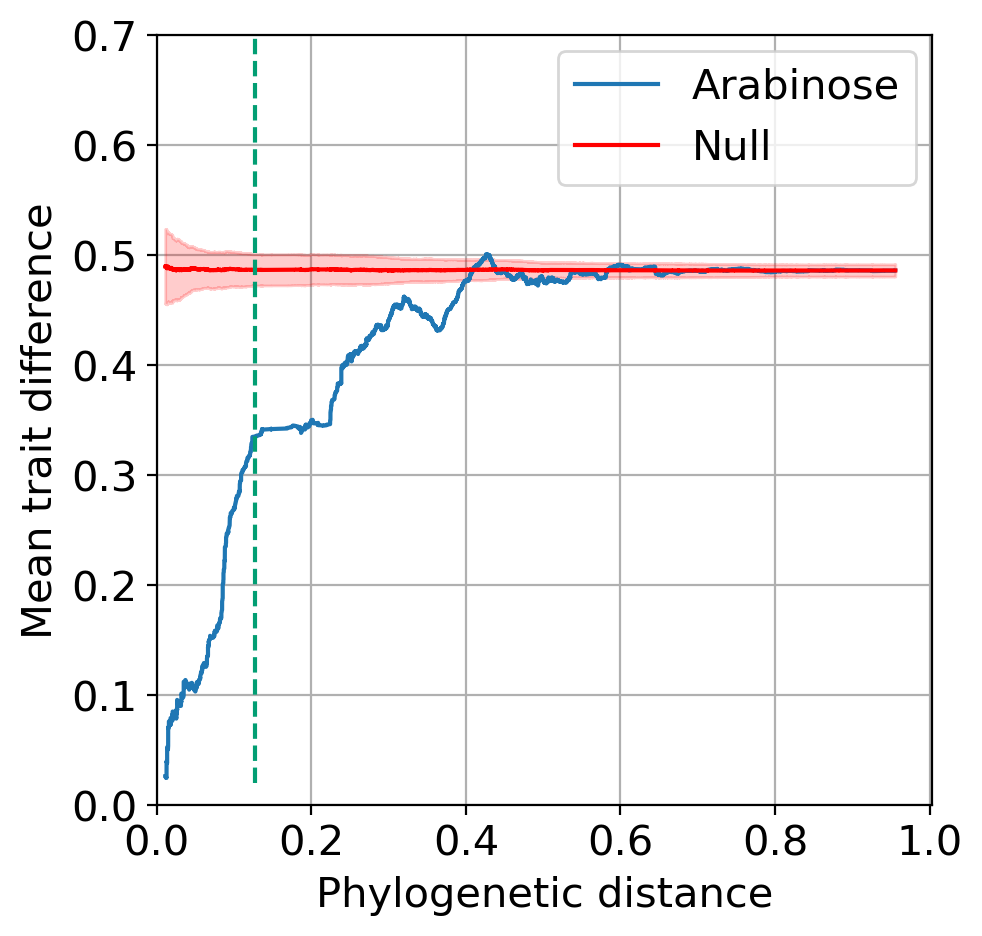

In [7]:
# Zeqian data
import math
col_wrap=5
n_bootstrap=100
x_min=0.01

DIR_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B"

df_dist=pd.read_pickle(f"{DIR_data}/zeqian_distance.pk")
# dist_mat=df_dist[['s1','s2','genome_distance']].pivot(index='s1',columns='s2',values='genome_distance')

carbons=zeqian['carbons']
c='Arabinose'

fig=plt.figure(figsize=(5,5))
ax=fig.gca()

arr_dist=df_dist['tree_distance'].values
arr_c=df_dist[c+'_distance'].values

_ind=pd.notna(arr_c)
arr_c=arr_c[_ind]
arr_dist=arr_dist[_ind]


# Plot real data 
xs, means=cal_accumulative_mean(arr_dist,arr_c)
_ind=xs>x_min
xs=xs[_ind]
means=means[_ind]
ax.plot(xs,means, label=c)

# Plot bootstrapped null
means_bs_all=[]
for i in tqdm(range(n_bootstrap),desc="Caluclating bootstrapped, "+c):
    xs_bs, means_bs=cal_accumulative_mean(arr_dist,np.random.choice(arr_c, len(arr_c), replace=True))
    means_bs_all.append(means_bs)
means_bs_mean=np.mean(means_bs_all,axis=0)
means_bs_std=np.std(means_bs_all,axis=0)
_ind=xs_bs>x_min
xs_bs=xs_bs[_ind]
means_bs_mean=means_bs_mean[_ind]
means_bs_std=means_bs_std[_ind]

ax.plot(xs_bs,means_bs_mean, label='Null',c='r')
ax.fill_between(xs_bs,means_bs_mean-means_bs_std,means_bs_mean+means_bs_std, alpha=0.2, color='r')

ax.grid()
ax.set_xlabel('Phylogenetic distance')
ax.set_ylabel("Mean trait difference")
ax.set_ylim(0,0.7)
ax.set_xlim(left=0)

# Cutoff

cutoffs=pd.read_pickle(f'{DIR_data}/zeqian_chi2.pk')['cutoffs']
ax.plot([cutoffs.iat[0,1],cutoffs.iat[0,1]],[0.02,0.7],c=COLORS[2],ls='--')

# legend out of plot
ax.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0., )

## Plot

In [10]:
# Zeqian 

DIR_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B"

# Calculate nearest neighbor distance distribution 

def cal_data_split_distance(df_dist, key, Splitter, splitter_params,
            n_splits=100,max_k=1):
    samples=df_dist['s1'].unique()
    # df_dist=df_dist.sort_values(['s1',key],ascending=[True,True])
    gb=df_dist.groupby('s1')
    df_nearest_neighbor=[]
    
    splitter=Splitter(**splitter_params)
    splits=splitter.generate_splits(samples,n_splits)

    distances=[]
    for test_samples in splits:
        train_samples=np.setdiff1d(samples,test_samples)
        for test_sample in test_samples:
            group=gb.get_group(test_sample)
            neighbors=np.sort(group[group['s2'].isin(train_samples)][key].values)[:max_k]
            distances.extend(neighbors)
    
    return distances 

df_dist=pd.read_pickle(f"{DIR_data}/zeqian_distance.pk")
cutoffs=pd.read_pickle(f'{DIR_data}/zeqian_chi2.pk')['cutoffs']

distances=cal_data_split_distance(df_dist, 'tree_distance', RandomSplitter, {'test_set_ratio':0.2})# Calculate nearest neighbor distance distribution 
df=pd.concat([cutoffs, pd.DataFrame({'carbon_name':['random_split']*len(distances), 'cutoff':distances})],axis=0,ignore_index=True)

distances=cal_data_split_distance(df_dist, 'tree_distance', LargeTreeTraverseOOCSplitter, {'test_set_range':(0.1,0.3), 'min_zeros':None, 'min_ones':None, 'time_out_iter':None,'tree':zeqian['tree'], 'growth_data':None}) # Calculate nearest neighbor distance distribution 
df=pd.concat([df, pd.DataFrame({'carbon_name':['ooc_split']*len(distances), 'cutoff':distances})],axis=0,ignore_index=True)


(0.0, 0.7)

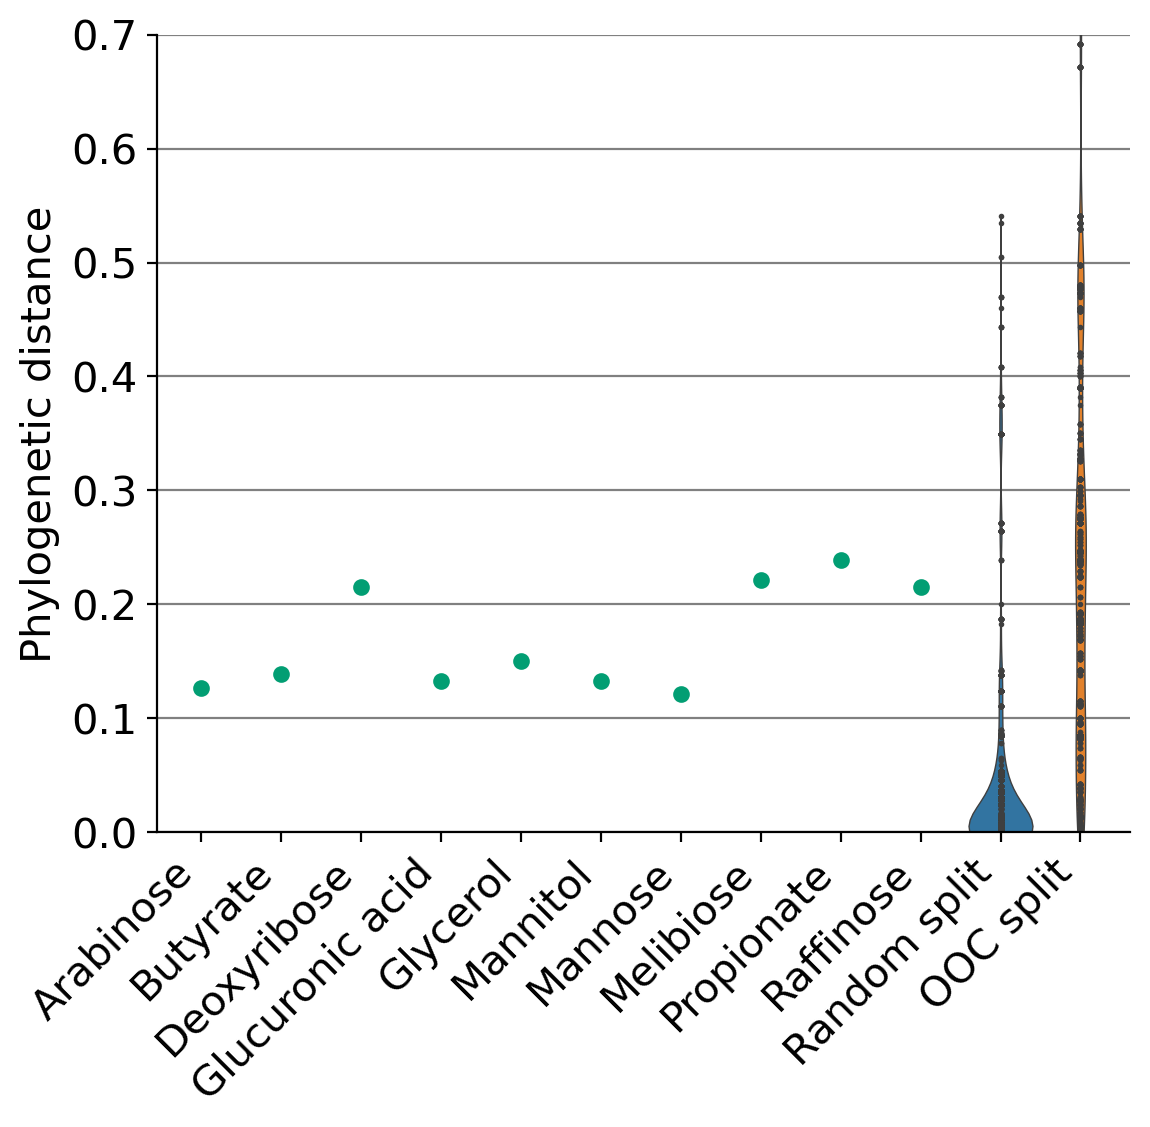

In [11]:
sns.catplot(data=df[df['carbon_name'].str.contains('split')], x='carbon_name', y='cutoff',kind='violin',cut=0,height=5, aspect=1.2, linewidth=0.5, inner='point')

spacing=1

xs=[spacing * -(i+1) for i in range(len(zeqian['carbons']))][::-1]
plt.scatter(xs, cutoffs['cutoff'].values, s=100, color=COLORS[2],marker='.')
plt.gca().yaxis.grid(color='gray')
plt.xticks(ticks=[*xs,0,1], labels=[*cutoffs['carbon_name'].values, "Random split",'OOC split'])

plt.xticks(rotation=45, ha='right')
plt.xlabel(None)
plt.ylabel("Phylogenetic distance")
plt.ylim(bottom=0,top=0.7)